In [1]:
%matplotlib notebook

import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wms.dbs import weadbs, hdf5
from wms.analysis import classification, damage
from wms.utils import periods

Using bladecontrol plotting style.
Registering webvis-style.


# Example of how to specify a damage case

### necessary information
needed for creating a damage classifier

In [2]:
# database name for the considered turbine
db = 'bc_t_02826'

# the damaged blade
dmg_blade = 1

# the blades without damage throughout the considered period (data_periods below)
# (we usually don't want to compare with data from a different damage case)
ok_blades = [2, 3]

# period in which the damage was present for sure
#   - it is unclear from when
#   - start = first SDA-warning in 150-350 Hz after that it occurred 
dmg_period = ('2019-03-18', '2019-10-05')

# Period in which the turbine was stopped due to damage. Actually stopped already 
# from 2020-01-09 08:00, but only after 12:30 pitch was > 90°. There are 
# measurements with pitch < 90° in between in this period, but they are rare.
# Flagging this period specifically, because signal energies in the ok blades 
# were on average markedly reduced during this shutdown even compared to cycles
# with similar pitch and wind measurements.
shutdown_period = ('2020-01-09 12:30', '2020-06-19')

# the full time period that should be investigated
# use this to restrict data to those periods with comparable 
# measurement conditions, e.g., same installed sensors, same turbine hardware
# also use this to exclude times with otherwise abnormal data, e.g., 
# repair times, or perhaps a different unrelated damage
# you can give several periods in a list
data_periods = [('2019', '2021')]

# periods in which given sensors were defect
# blade 3 sensors destroyed during repair
sens_defects = {}

In [12]:
hdfdir = pathlib.Path(f'D:/damages/V136_Hinterkante/{db}/_current')

### optional information
these may, or may not be used to create a damage classifier

In [4]:
# normalisation instructions known to result in damage seen in data
# see wms.dbs.weadbs.SEData.normalise for options
normalisation = dict(normhow='div')

# frequency bands in which the damage is seen (if previously identified,
# but this will most likely be ignored during classifier generation)
fbands = pd.IntervalIndex.from_breaks(np.arange(0, 501, 2))

### Peaks and troughs from mean spectograms

In [5]:
fbands = dict(
    edge=[0, 0.34, 0.85, 1.15, 2.35, 2.8, 3.25, 4.8, 5.2, 6, 6.5, 8.5, 9.1, 
          10, 10.9, 13.6, 14.5, 15.2, 15.8, 18, 18.9, 19.6, 20.8, 22.9, 23.7,
          28, 28.9, 30.2, 31.3, 32.3, 33.7, 34.6, 36, 36.9, 38, 39.3, 40.5, 42, 
          43.6, 46.7, 48.3, 50, 52, 53.8, 55, 59.5, 62, 65, 67, 71.5, 73.3, 75,
          76.4, 78.8, 79.8, 81.6, 83.3, 86, 89, 99.7, 100.4, 102.9, 105, 110,
          112.5, 116, 120, 125, 129, 131, 136, 143.5, 149.3, 150.7, 154, 158,
          161.5, 165, 167.5, 170, 173.5, 177, 180.5, 188, 192, 195, 197, 204,
          212, 216.5, 222, 228, 230.5, 242, 247, 252, 265, 273, 299.7, 300.5,
          318, 320, 324, 325.5, 340, 346, 349.5, 350.5, 378, 392, 399.5, 400.5,
          420, 430, 442, 452, 467, 479, 483, 492, 500],
    flap=[0, 0.34, 0.6, 0.85, 1.15, 1.7, 2.3, 2.7, 3.2, 3.7, 4.75, 5.2, 
          5.5, 6.2, 7.35, 8, 8.7, 8.85, 9.1, 11.05, 11.5, 12.95, 13.4, 14.4,
          15.2, 15.7, 16.2, 17, 18.5, 18.9, 20, 20.6, 22.2, 23, 23.6, 24.2, 25.1,
          28.3, 28.9, 30.2, 33.5, 37.2, 39, 40.5, 42.9, 45, 48.3, 50, 51.9,
          53.6, 55, 58.3, 61.2, 63.9, 66.7, 68, 69.5, 70.6, 71.9, 75, 76.4,
          77.5, 79, 80, 81.3, 82.8, 84.5, 85.8, 86.7, 91.2, 92.8, 96.8, 99.7,
          100.4, 108, 117, 119.5, 123, 131, 133.5, 138, 144.5, 149.3, 150.7,
          158, 161, 169, 171.5, 174.5, 178.5, 182, 187, 192, 196, 203, 207, 
          210, 213, 221, 223.5, 230.5, 244, 252, 265, 273, 299.7, 300.5,
          318, 320, 324, 325.5, 340, 346, 349.5, 350.5, 378, 392, 399.5, 400.5,
          420, 430, 442, 452, 467, 479, 483, 492, 500])

## Data conversions

In [50]:
loader = hdf5.HDFSpecs2sda(hdfdir, hdfdir / 'sda_from_specs.h5', 
                           min_itemsize={'timezone': 4})
_cts = loader.load(('2019', '2021'), dt=pd.Timedelta(days=60), verbose=1)

using file bc_t_02491_af_0
loading data for (2018-12-31 23:00:00.000000001+00:00, 2019-03-01 23:00:00.000000001+00:00)
loading data for (2019-03-01 23:00:00.000000001+00:00, 2019-04-30 23:00:00.000000001+00:00)
loading data for (2019-04-30 22:13:39.000000001+00:00, 2019-06-29 22:13:38.000000001+00:00)
loading data for (2019-06-29 21:31:02.000000001+00:00, 2019-08-28 21:31:01.000000001+00:00)
loading data for (2019-08-28 21:24:50.000000001+00:00, 2019-10-27 21:24:49.000000001+00:00)
loading data for (2019-10-27 20:29:40.000000001+00:00, 2019-12-26 20:29:39.000000001+00:00)
loading data for (2019-12-26 20:20:19.000000001+00:00, 2020-02-24 20:20:18.000000001+00:00)
loading data for (2019-12-31 04:36:35.000000001+00:00, 2020-02-29 04:36:34.000000001+00:00)
using file bc_t_02491_af_1
loading data for (2019-12-31 05:02:32.000000001+00:00, 2020-02-29 04:36:34.000000001+00:00)
loading data for (2020-02-29 04:30:02.000000001+00:00, 2020-04-29 04:30:01.000000001+00:00)
loading data for (2020-04-

In [18]:
loader = hdf5.HDFSpecs2sda(hdfdir, hdfdir / 'sda_from_specs_highres.h5', 
                           fbands=np.arange(0, 50, 0.5), min_itemsize={'timezone': 4})
_cts = loader.load(('2019', '2020-01-09'), dt=pd.Timedelta(days=60), verbose=1)

using file bc_t_02491_af_0
loading data for (2018-12-31 23:00:00.000000001+00:00, 2019-03-01 23:00:00.000000001+00:00)
loading data for (2019-03-01 23:00:00.000000001+00:00, 2019-04-30 23:00:00.000000001+00:00)
loading data for (2019-04-30 22:13:39.000000001+00:00, 2019-06-29 22:13:38.000000001+00:00)
loading data for (2019-06-29 21:31:02.000000001+00:00, 2019-08-28 21:31:01.000000001+00:00)
loading data for (2019-08-28 21:24:50.000000001+00:00, 2019-10-27 21:24:49.000000001+00:00)
loading data for (2019-10-27 20:29:40.000000001+00:00, 2019-12-26 20:29:39.000000001+00:00)
loading data for (2019-12-26 20:20:19.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
loading data for (2019-12-31 04:36:35.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
using file bc_t_02491_af_1
loading data for (2019-12-31 05:02:32.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
loading data for (2020-01-08 22:29:35.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
optimising sda_from_specs_

In [21]:
loader = hdf5.HDFSpecs2sda(hdfdir, hdfdir / 'peaks_edge.h5', 
                           fbands=fbands['edge'], channels='edge', min_itemsize={'timezone': 4})
_cts = loader.load(data_periods[0], dt=pd.Timedelta(days=60), verbose=1)

using file bc_t_02826_af_0
loading data for (2018-12-31 23:00:00.000000001+00:00, 2019-03-01 23:00:00.000000001+00:00)
loading data for (2019-03-01 23:00:00.000000001+00:00, 2019-04-30 23:00:00.000000001+00:00)
loading data for (2019-04-30 22:14:48.000000001+00:00, 2019-06-29 22:14:47.000000001+00:00)
loading data for (2019-06-05 20:15:30.000000001+00:00, 2019-08-04 20:15:29.000000001+00:00)
loading data for (2019-08-04 20:14:27.000000001+00:00, 2019-10-03 20:14:26.000000001+00:00)
loading data for (2019-10-03 20:11:55.000000001+00:00, 2019-12-02 20:11:54.000000001+00:00)
loading data for (2019-12-02 15:12:44.000000001+00:00, 2020-01-31 15:12:43.000000001+00:00)
loading data for (2020-01-31 15:01:29.000000001+00:00, 2020-03-31 15:01:28.000000001+00:00)
loading data for (2020-02-09 01:13:44.000000001+00:00, 2020-04-09 01:13:43.000000001+00:00)
using file bc_t_02826_af_1
loading data for (2020-02-09 02:10:29.000000001+00:00, 2020-04-09 01:13:43.000000001+00:00)
loading data for (2020-04-

In [22]:
loader = hdf5.HDFSpecs2sda(hdfdir, hdfdir / 'peaks_flap.h5', 
                           fbands=fbands['flap'], channels='flap', min_itemsize={'timezone': 4})
_cts = loader.load(data_periods[0], dt=pd.Timedelta(days=60), verbose=1)

using file bc_t_02826_af_0
loading data for (2018-12-31 23:00:00.000000001+00:00, 2019-03-01 23:00:00.000000001+00:00)
loading data for (2019-03-01 23:00:00.000000001+00:00, 2019-04-30 23:00:00.000000001+00:00)
loading data for (2019-04-30 22:14:48.000000001+00:00, 2019-06-29 22:14:47.000000001+00:00)
loading data for (2019-06-05 20:15:30.000000001+00:00, 2019-08-04 20:15:29.000000001+00:00)
loading data for (2019-08-04 20:14:27.000000001+00:00, 2019-10-03 20:14:26.000000001+00:00)
loading data for (2019-10-03 20:11:55.000000001+00:00, 2019-12-02 20:11:54.000000001+00:00)
loading data for (2019-12-02 15:12:44.000000001+00:00, 2020-01-31 15:12:43.000000001+00:00)
loading data for (2020-01-31 15:01:29.000000001+00:00, 2020-03-31 15:01:28.000000001+00:00)
loading data for (2020-02-09 01:13:44.000000001+00:00, 2020-04-09 01:13:43.000000001+00:00)
using file bc_t_02826_af_1
loading data for (2020-02-09 02:10:29.000000001+00:00, 2020-04-09 01:13:43.000000001+00:00)
loading data for (2020-04-

## Overview over SDA

In [23]:
peaks_edge = weadbs.SEData.from_hdf(hdfdir / 'peaks_edge.h5')

<IPython.core.display.Javascript object>


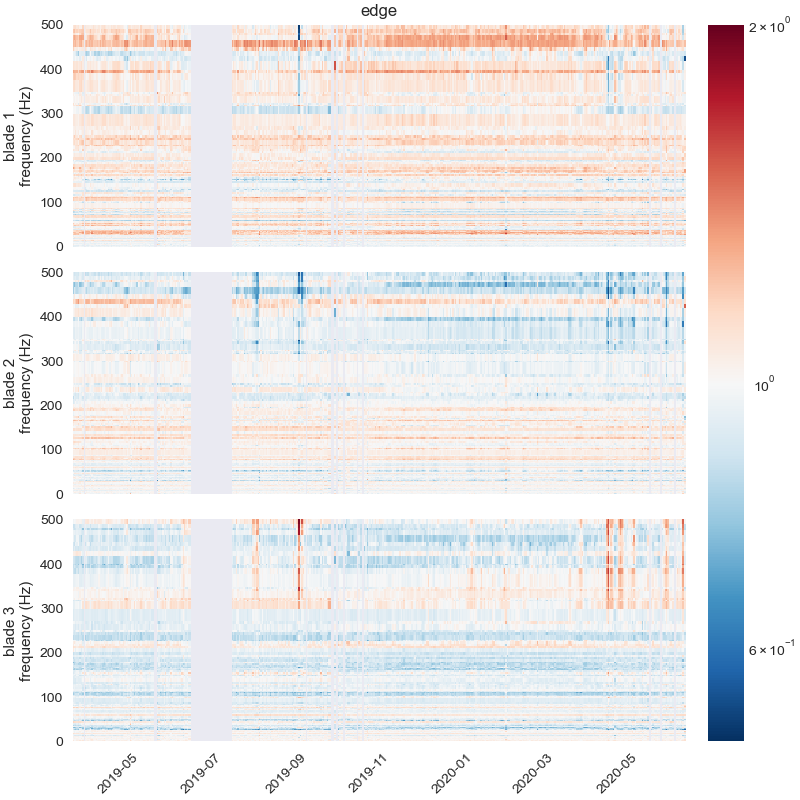

In [24]:
fig, axes = (peaks_edge.select_st({'omega_mean': (0.05,)})
             .plot_allse_timecourse(normkws={'normhow': 'div'}, ori='edge', resample='D'))

In [25]:
peaks_flap = weadbs.SEData.from_hdf(hdfdir / 'peaks_flap.h5')

<IPython.core.display.Javascript object>


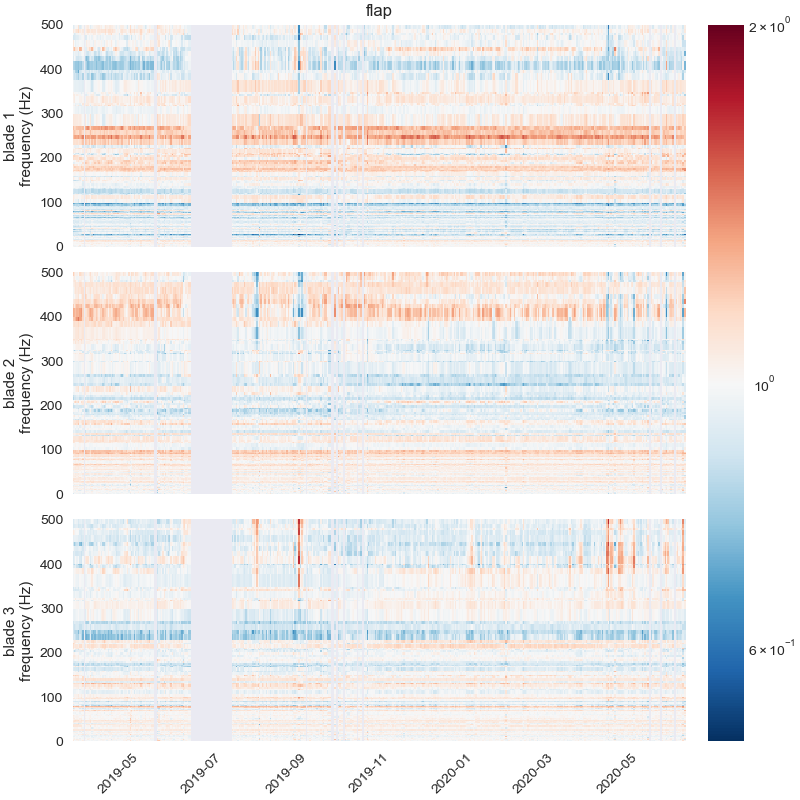

In [26]:
fig, axes = (peaks_flap.select_st({'omega_mean': (0.05,)})
             .plot_allse_timecourse(normkws={'normhow': 'div'}, ori='flap', resample='D'))

In [20]:
sedhigh = weadbs.SEData.from_hdf(hdfdir / 'sda_from_specs_highres.h5')

<IPython.core.display.Javascript object>


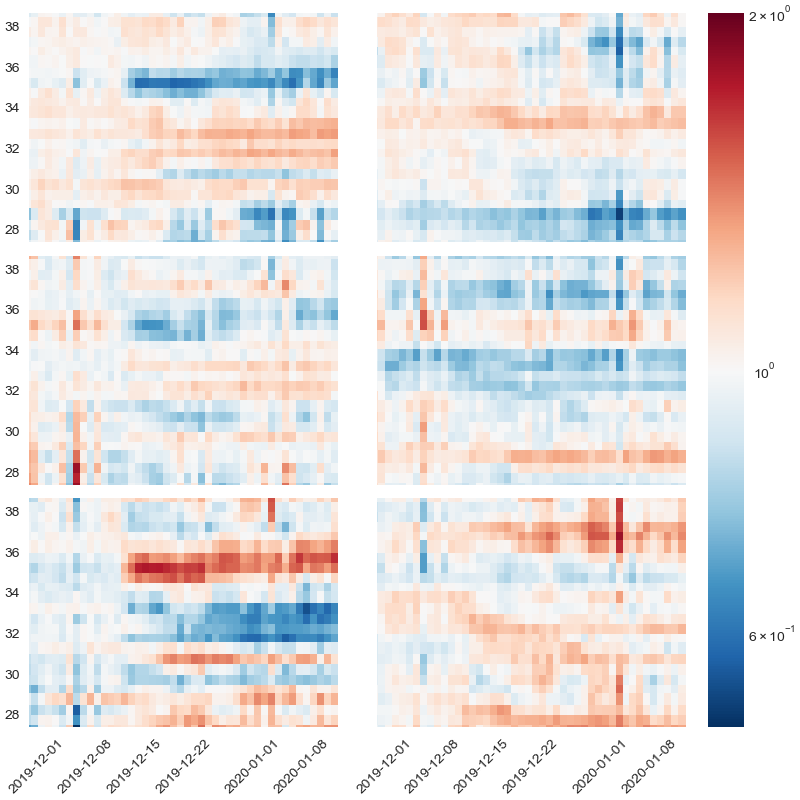

In [21]:
fig, axes = (sedhigh.select_st({'omega_mean': (0.05,)})
             .plot_allse_timecourse(normkws={'normhow': 'div'}, resample='D'))

In [7]:
specsed = weadbs.SEData.from_hdf(hdfdir / 'sda_from_specs.h5', 
                                 where={'create_time': ('2019', '2020-01-09')})

<IPython.core.display.Javascript object>


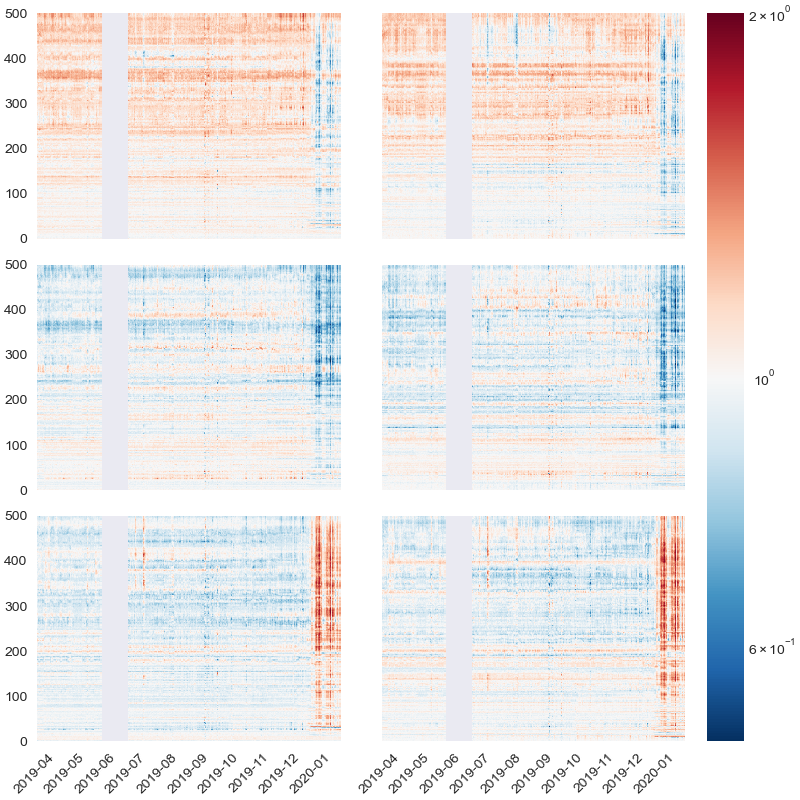

In [8]:
fig, axes = (specsed.select_st({'omega_mean': (0.05,)})
             .plot_allse_timecourse(normkws={'normhow': 'div'}, resample='D'))

## Find peaks in spectrogram

In [8]:
opstate = {'temperature_mean': (8, 12), 'omega_mean': (0.11, 0.13)}

In [13]:
loader = hdf5.FilterLoader(opstate, 'af', hdfdir.parent)

In [14]:
specs_dmg, _ticks, _cts = loader.load(dmg_period, channels='blades')
specs_dmg = weadbs.SEData(specs_dmg)

loading ... 100% done.
combining data ... done.


In [22]:
specs_dmg.

channel                   Sensor.Blade#1.Edge                             \
start_f                            0.000000     0.061035      0.122070     
2019-03-22 00:01:14+01:00          175.224899  6136.232910  14586.957031   
2019-03-23 18:16:16+01:00          213.960693  7743.166504  13096.792969   
2019-03-24 15:13:41+01:00          540.010925  7851.062500  12753.830078   
2019-03-27 20:06:22+01:00          477.681610  7724.112793  13056.528320   
2019-03-29 22:11:45+01:00           41.716400  6953.207520  14022.277344   
...                                       ...          ...           ...   
2019-09-09 01:13:49+02:00          104.705299  6463.513184  14445.230469   
2019-10-02 19:03:35+02:00          268.523804  7398.403320  13631.808594   
2019-10-02 21:16:35+02:00          612.224792  7934.699219  12893.950195   
2019-10-03 14:13:33+02:00           77.939003  6685.364746  14385.719727   
2019-10-04 00:06:05+02:00          116.027702  7190.245117  13862.941406   

channel                                                                     \
start_f                     0.183105    0.244141    0.305176    0.366211     
2019-03-22 00:01:14+01:00  8536.258789  350.346008   61.493000   37.272202   
2019-03-23 18:16:16+01:00  5580.313965  138.534393  147.589798  151.727997   
2019-03-24 15:13:41+01:00  5065.103516  278.892090   56.882801   52.159100   
2019-03-27 20:06:22+01:00  5444.416992  211.475204   67.523399   79.716003   
2019-03-29 22:11:45+01:00  7094.227539   63.781700   51.593498   73.951698   
...                                ...         ...         ...         ...   
2019-09-09 01:13:49+02:00  7999.778809  206.516800   77.530296   66.436401   
2019-10-02 19:03:35+02:00  6183.018066  213.142303   73.551697   67.882202   
2019-10-02 21:16:35+02:00  5120.768555  272.506500  128.339401   86.175201   
2019-10-03 14:13:33+02:00  7687.250977   81.601196   53.731499   34.599998   
2019-10-04 00:06:05+02:00  6673.630859   28.385799   62.285500   53.506001   

channel                                                     ...  \
start_f                   0.427246   0.488281   0.549316    ...   
2019-03-22 00:01:14+01:00  39.348801  22.560499  22.763599  ...   
2019-03-23 18:16:16+01:00  39.572399  37.546299  54.248001  ...   
2019-03-24 15:13:41+01:00  25.298800  13.844200  13.721000  ...   
2019-03-27 20:06:22+01:00  31.502501  23.615000  54.847599  ...   
2019-03-29 22:11:45+01:00  35.271099  10.882900  19.343000  ...   
...                              ...        ...        ...  ...   
2019-09-09 01:13:49+02:00  53.893101  31.205400  31.185499  ...   
2019-10-02 19:03:35+02:00  41.004101  18.885599  36.722900  ...   
2019-10-02 21:16:35+02:00  46.994499  39.069000  48.369301  ...   
2019-10-03 14:13:33+02:00  25.872801  14.014900  14.558800  ...   
2019-10-04 00:06:05+02:00  20.887800  24.046700  17.992001  ...   

channel                   Sensor.Blade#3.Flap                        \
start_f                            499.389648 499.450684 499.511719   
2019-03-22 00:01:14+01:00              0.9916     0.7913     0.7052   
2019-03-23 18:16:16+01:00              0.4350     0.6893     0.6370   
2019-03-24 15:13:41+01:00              0.3868     0.5026     0.4863   
2019-03-27 20:06:22+01:00              0.5193     0.4300     0.4245   
2019-03-29 22:11:45+01:00              1.4531     1.6088     0.9828   
...                                       ...        ...        ...   
2019-09-09 01:13:49+02:00              0.3557     0.6286     0.6780   
2019-10-02 19:03:35+02:00              0.4622     0.8806     0.9540   
2019-10-02 21:16:35+02:00              0.7045     0.9380     0.4036   
2019-10-03 14:13:33+02:00              0.8414     0.8624     0.8193   
2019-10-04 00:06:05+02:00              0.9785     1.2122     1.1864   

channel                                                                \
start_f                   499.572754 499.633789 499.694824 499.755859   
2019-03-22 00:01:14+01:00     0.7237     0.6674     0.

<IPython.core.display.Javascript object>


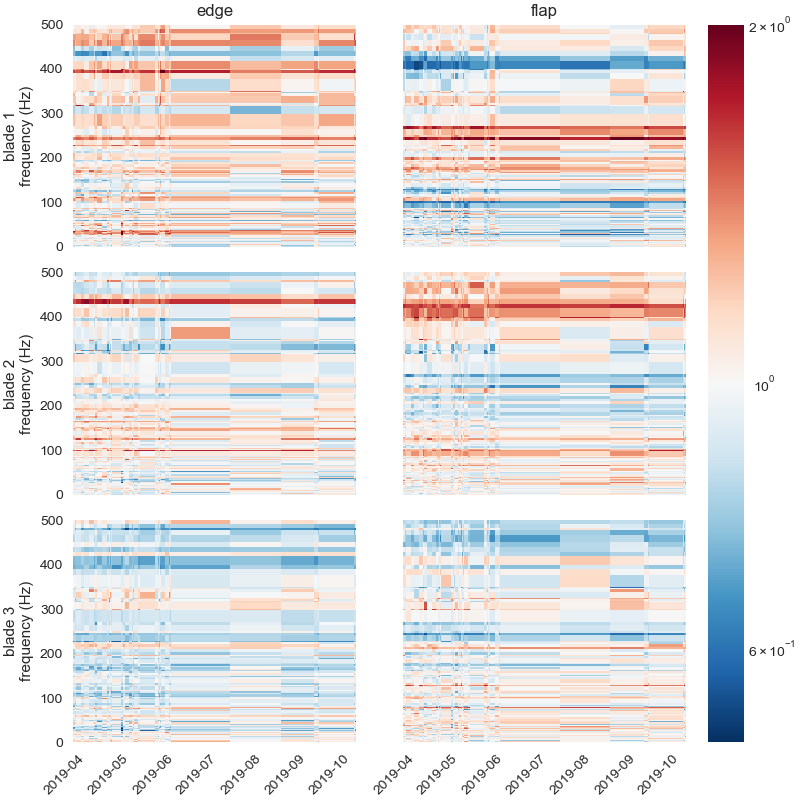

(<Figure size 800x800 with 7 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001749DB08>,
       dtype=object))

In [25]:
specs_dmg.agg_freq(fbands['edge']).plot_allse_timecourse(resample=None)

<IPython.core.display.Javascript object>


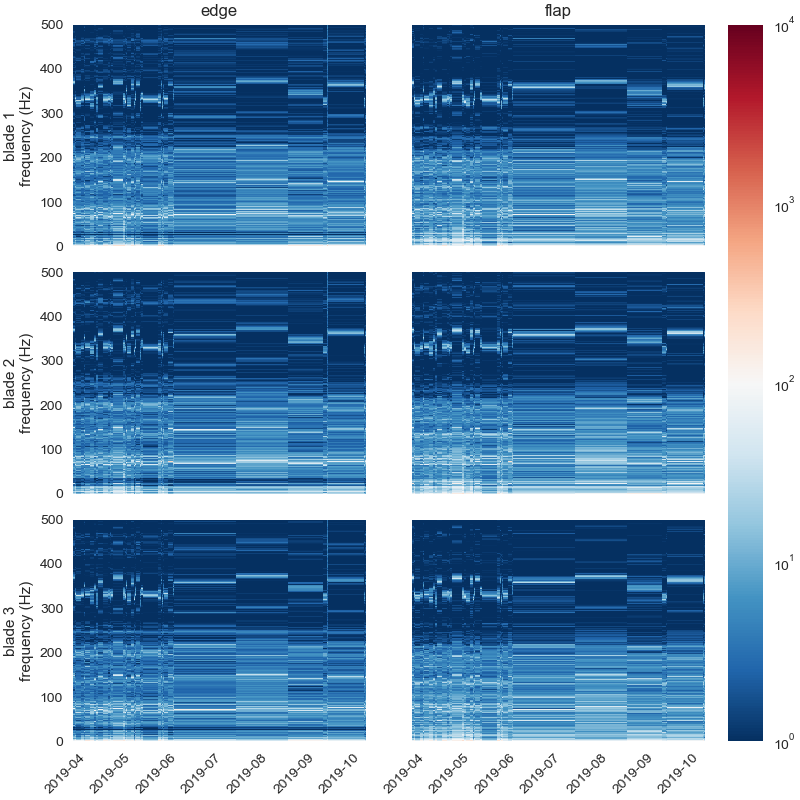

(<Figure size 800x800 with 7 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012EB82C8>,
       dtype=object))

In [24]:
specs_dmg.plot_allse_timecourse(normkws=dict(normhow=None), resample=None, vmin=1, vmax=10000)

<IPython.core.display.Javascript object>


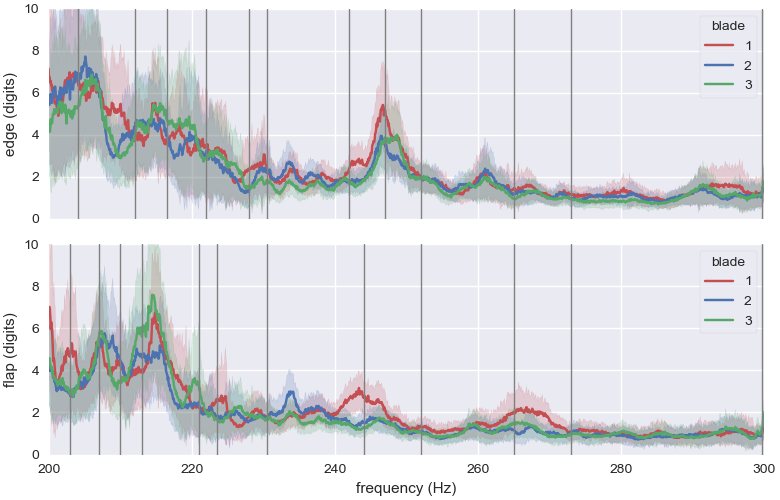

In [15]:
axes = specs_dmg.plot_mean_se(samples=0, fbands=fbands)

In [26]:
axes[-1].set_xlim(200, 300)
axes[-1].set_ylim(0, 10)

(0.0, 10.0)

## BladeDamage class and DI2

In [8]:
from wms.analysis import damage

In [9]:
dmg = damage.BladeDamage(db, '', dmg_period, dmg_blade, [('2019', '2020-01-09')], sens_defects)

### Flap

processing wind bin 18 / 18 ...done.


<IPython.core.display.Javascript object>


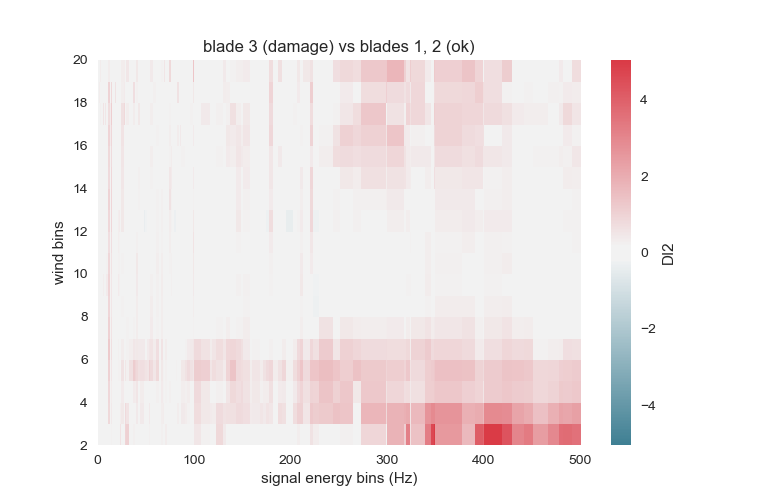

In [18]:
dmg.compute_se_DI2_profile(
    'flap', 'wind_mean', peaks_flap, vmin=2, vmax=20, vstep=1,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d', show=dict(vmin=0.2))

processing power bin 19 / 19 ...done.


<IPython.core.display.Javascript object>


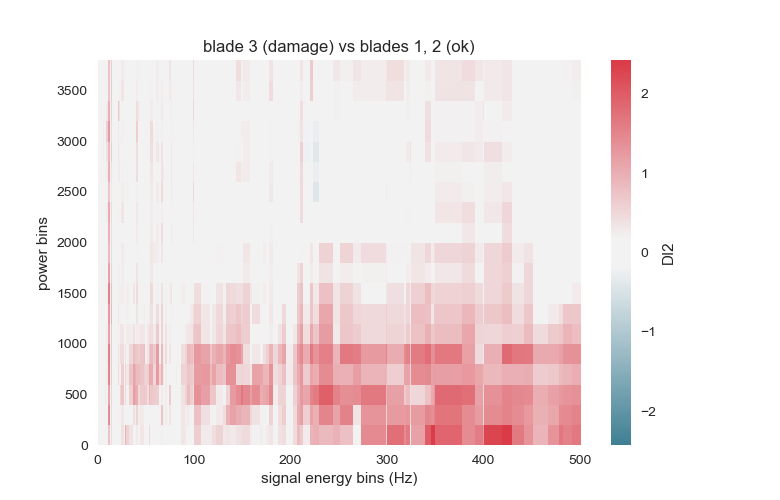

In [38]:
dmg.compute_se_DI2_profile(
    'flap', 'power_mean', peaks_flap, vmin=0, vmax=3800, vstep=200,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d', show=dict(vmin=0.2))

processing omega bin  3 / 16 ...

u:\wms-python\wms\analysis\damage.py:515: RuntimeWarning: There are channels without data in certain periods - subsampling will not work as intended! (1_flap: damage, 1_flap: after, 2_flap: damage, 2_flap: after, 3_flap: damage, 3_flap: after)
  for ind in nodata])), RuntimeWarning)


processing omega bin 16 / 16 ...done.


<IPython.core.display.Javascript object>


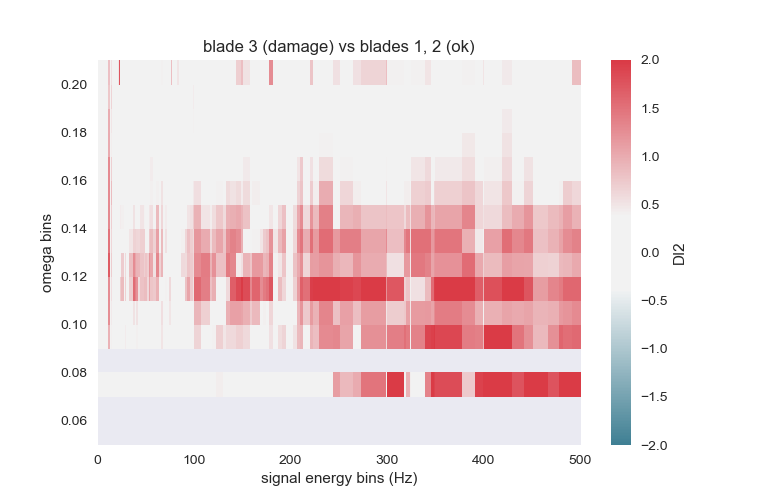

In [39]:
dmg.compute_se_DI2_profile(
    'flap', 'omega_mean', peaks_flap, vmin=0.05, vmax=0.21, vstep=0.01,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d', show=dict(vmin=0.4, vmax=2))

<IPython.core.display.Javascript object>


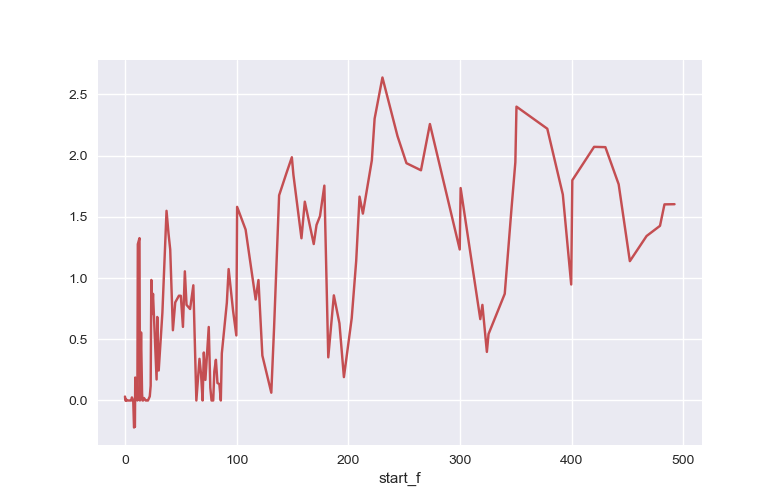

In [32]:
dmg.load_se({'omega_mean': (0.05, ), 'omega_mean': (0.11, 0.12)}, 'flap', peaks_flap)
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

<IPython.core.display.Javascript object>


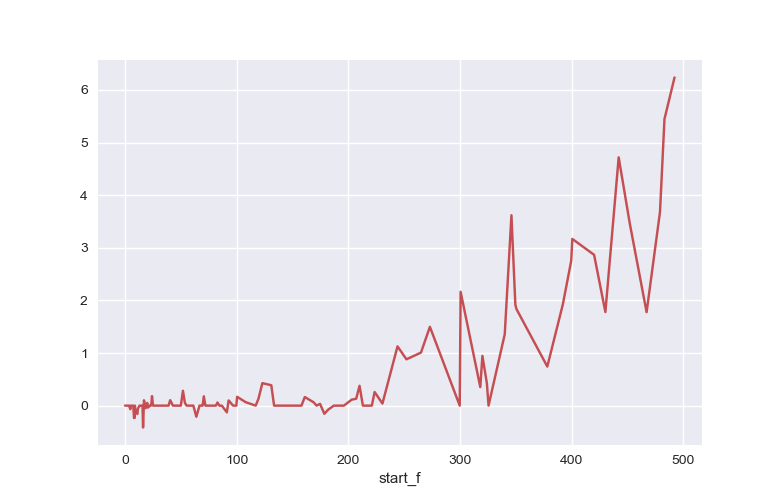

In [31]:
dmg.load_se({'omega_mean': (0.05, ), 'omega_mean': (0.07, 0.08)}, 'flap', peaks_flap)
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

### Edge

processing wind bin 18 / 18 ...done.


<IPython.core.display.Javascript object>


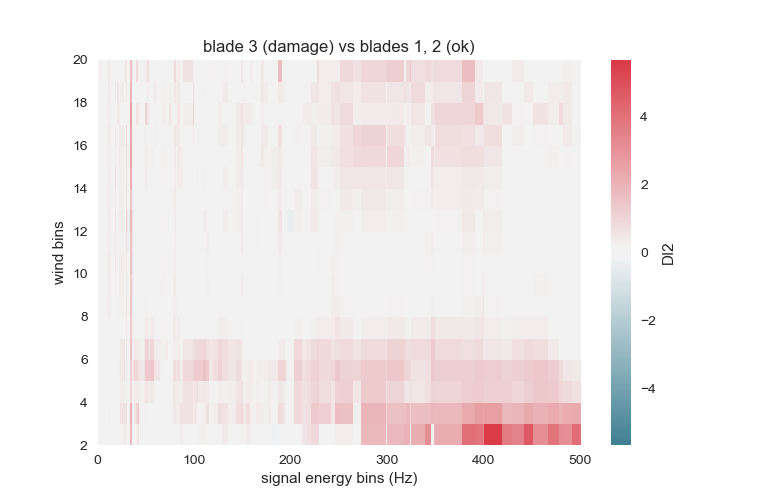

In [33]:
dmg.compute_se_DI2_profile(
    'edge', 'wind_mean', peaks_edge, vmin=2, vmax=20, vstep=1,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d', show=dict(vmin=0.2))

processing power bin 20 / 20 ...done.


u:\wms-python\wms\analysis\damage.py:515: RuntimeWarning: There are channels without data in certain periods - subsampling will not work as intended! (1_edge: before, 1_edge: damage, 1_edge: after, 2_edge: before, 2_edge: damage, 2_edge: after, 3_edge: before, 3_edge: damage, 3_edge: after)
  for ind in nodata])), RuntimeWarning)


<IPython.core.display.Javascript object>


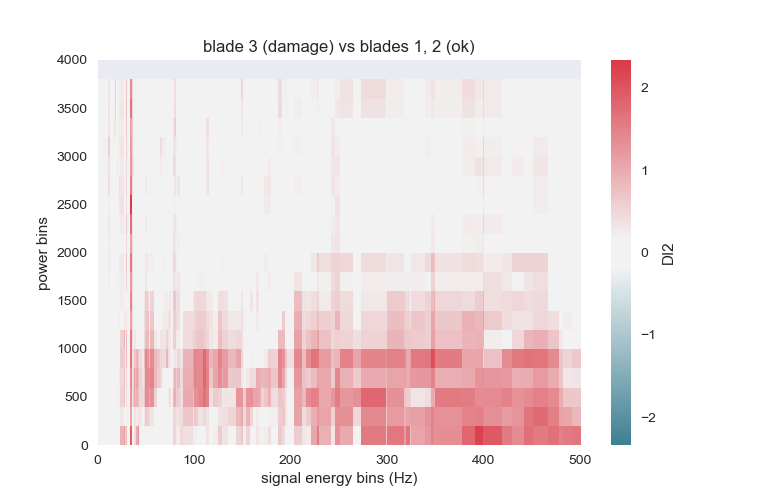

In [34]:
dmg.compute_se_DI2_profile(
    'edge', 'power_mean', peaks_edge, vmin=0, vmax=4000, vstep=200,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d', show=dict(vmin=0.2))

processing omega bin  3 / 16 ...

u:\wms-python\wms\analysis\damage.py:515: RuntimeWarning: There are channels without data in certain periods - subsampling will not work as intended! (1_edge: damage, 1_edge: after, 2_edge: damage, 2_edge: after, 3_edge: damage, 3_edge: after)
  for ind in nodata])), RuntimeWarning)


processing omega bin 16 / 16 ...done.


<IPython.core.display.Javascript object>


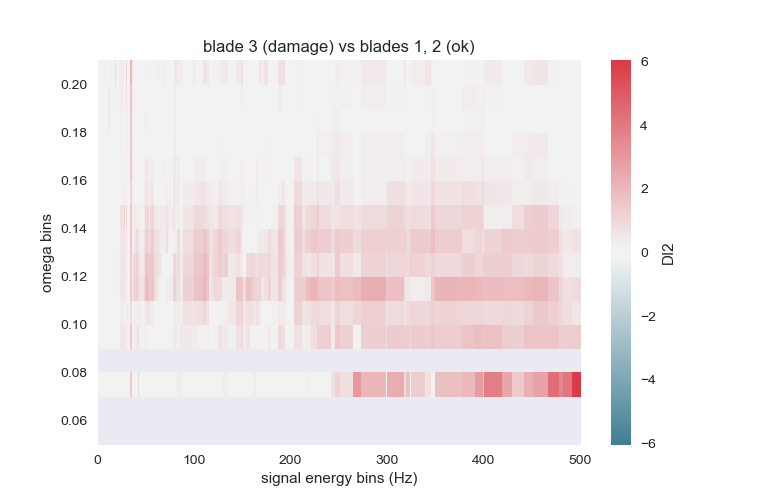

In [35]:
dmg.compute_se_DI2_profile(
    'edge', 'omega_mean', peaks_edge, vmin=0.05, vmax=0.21, vstep=0.01,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d', show=dict(vmin=0.2))

<IPython.core.display.Javascript object>


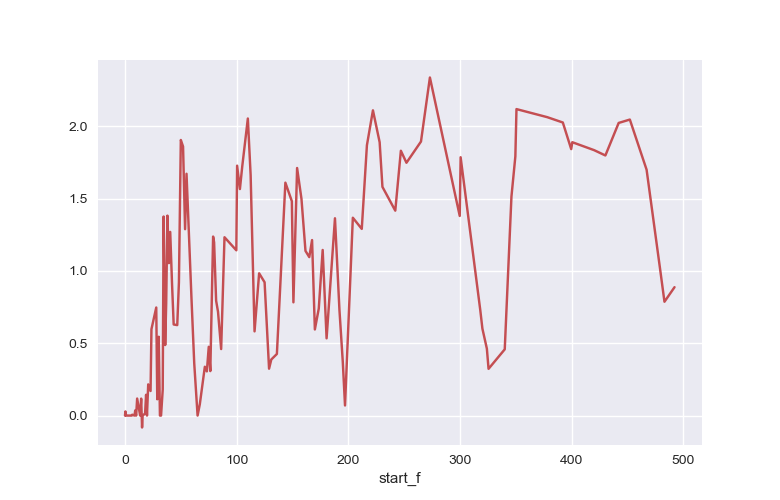

In [36]:
dmg.load_se({'omega_mean': (0.05, ), 'omega_mean': (0.11, 0.12)}, 'edge', peaks_edge)
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

<IPython.core.display.Javascript object>


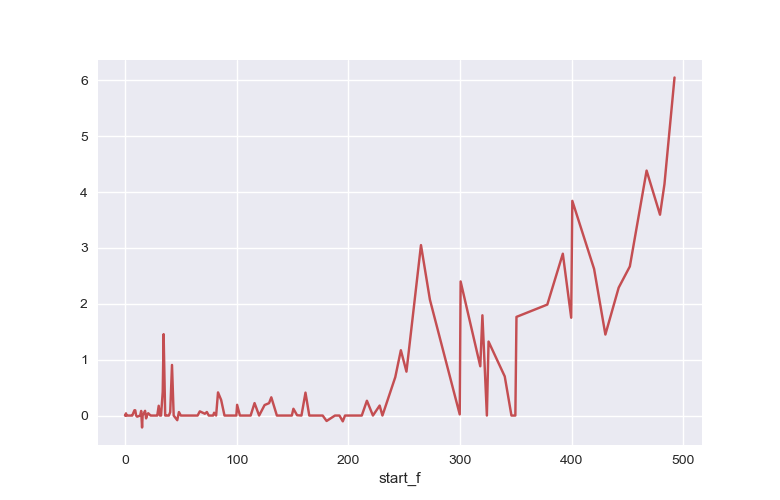

In [37]:
dmg.load_se({'omega_mean': (0.05, ), 'omega_mean': (0.07, 0.08)}, 'edge', peaks_edge)
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

## Damage classifier

In [5]:
stvars = ['azimuth_mean', 'azimuth_sigma', 'omega_mean', 'omega_sigma', 'power_mean', 'power_sigma',
          'temperature_mean', 'wind_mean', 'wind_sigma']

In [6]:
ori = 'flap'

In [7]:
clf = classification.SEDBladeClassifier(
    {'omega_mean': 0}, ori, fbands, fbands.left, normalisation, stvars, 
    intended_for={'Datenbankname': f'cmrblba_{db}'})

In [8]:
train_periods = periods.CompactPeriods(data_periods)

In [9]:
defect_periods = periods.CompactPeriods([])
for _ch in sens_defects:
    if _ch.endswith(ori):
        defect_periods = defect_periods | periods.CompactPeriods(sens_defects[_ch])

In [10]:
dmg_period = periods.TimeInterval(dmg_period)

In [11]:
X, y = clf.load_Xy_from_hdf(
    hdfdir / 'sda_from_specs.h5', f'cmrblba_{db}',
    train_periods - defect_periods - dmg_period, 
    train_periods - defect_periods - ~dmg_period,
    dmg_blade)

loading chunk starting from 2020-06-08 ... done.
shape of loaded X: (14844, 259)


In [14]:
X

f000      f002      f004      f006      f008  \
blade create_time                                                             
1     2019-03-15 16:14:55  0.897955  1.025479  0.987408  1.067281  1.048028   
      2019-03-15 17:31:04  0.870892  1.013270  1.020292  0.982393  0.978448   
      2019-03-15 18:29:33  0.890992  1.082827  1.002082  1.015003  0.932539   
      2019-03-15 21:31:42  0.997020  1.082863  0.973670  1.008801  1.075698   
      2019-03-17 00:31:57  0.929491  1.035474  1.052830  1.093288  1.036612   
...                             ...       ...       ...       ...       ...   
3     2020-06-02 15:29:03  1.431720  2.280338  2.487401  2.503232  2.871516   
      2020-06-02 16:27:24  1.504246  1.716495  1.883184  2.050153  2.691138   
      2020-06-02 23:13:17  1.477992  1.428034  1.806784  1.625605  2.437956   
      2020-06-03 00:30:17  1.552077  1.796606  1.788021  1.862963  2.601488   
      2020-06-03 01:27:54  1.361622  1.937388  2.339934  2.728995  2.783438   

                               f010      f012      f014      f016      f018  \
blade create_time                                                             
1     2019-03-15 16:14:55  1.058616  0.963363  1.074667  1.208271  1.048604   
      2019-03-15 17:31:04  1.021232  1.070502  1.053757  1.062989  0.997381   
      2019-03-15 18:29:33  1.006902  1.042532  0.985329  1.049800  0.949214   
      2019-03-15 21:31:42  1.041677  1.017107  0.939952  1.188005  0.970436   
      2019-03-17 00:31:57  0.955832  1.078743  1.035189  1.025892  0.761416   
...                             ...       ...       ...       ...       ...   
3     2020-06-02 15:29:03  2.515970  2.398739  2.516096  2.361862  2.798239   
      2020-06-02 16:27:24  2.027417  2.031318  2.076510  2.072294  2.635675   
      2020-06-02 23:13:17  1.510566  1.660268  1.543004  1.538940  2.619967   
      2020-06-03 00:30:17  2.030216  1.798979  1.837265  1.900591  2.650112   
      2020-06-03 01:27:54  2.776745  2.815729  2.781320  2.819612  2.900676   

                           ...      f498  azimuth_mean  azimuth_sigma  \
blade create_time          ...                                          
1     2019-03-15 16:14:55  ...  1.069964       268.348   5.863160e-06   
      2019-03-15 17:31:04  ...  0.926054       268.900  -3.542090e-16   
      2019-03-15 18:29:33  ...  1.054740       270.800   4.244650e-16   
      2019-03-15 21:31:42  ...  1.448218       262.800   3.210860e-16   
      2019-03-17 00:31:57  ...  1.192033       245.992   1.121130e-07   
...                        ...       ...           ...            ...   
3     2020-06-02 15:29:03  ...  1.485082       339.700   2.460050e-16   
      2020-06-02 16:27:24  ...  1.405027       339.700   2.460050e-16   
      2020-06-02 23:13:17  ...  2.008924       339.700   2.653040e-16   
      2020-06-03 00:30:17  ...  1.575320       339.700   2.653040e-16   
      2020-06-03 01:27:54  ...  2.721363       339.700   1.611670e-16   

                           omega_mean  omega_sigma  power_mean  power_sigma  \
blade create_time                                                             
1     2019-03-15 16:14:55         0.0          0.0     -7.5600      57.0319   
      2019-03-15 17:31:04         0.0          0.0     -4.0400      89.0975   
      2019-03-15 18:29:33         0.0          0.0     -4.6000      96.2023   
      2019-03-15 21:31:42         0.0          0.0    -16.7308      51.9294   
      2019-03-17 00:31:57         0.0          0.0    -24.6000      17.4844   
...                               ...          ...         ...          ...   
3     2020-06-02 15:29:03         0.0          0.0     -2.0000       0.0000   
      2020-06-02 16:27:24         0.0          0.0     -5.0000       0.0000   
      2020-06-02 23:13:17         0.0          0.0     -2.0000       0.0000   
      2020-06-03 00:30:17         0.0          0.0     -2.0000       0.0000   
      2020-06-03 01:27:54         0.0          0.0     -2.0000       0.0000  